任务：基于zgpa_train.csv数据，建立RNN模型，预测股价  
1.完成数据预处理，将序列数据转化为可用于RNN输入的数据  
2.对新数据zgpa_test.csv进行预测，可视化结果  
3.存储预测结果，并观察局部预测结果  
备注：模型结构：单层RNN，输出有五个神经元：每次使用前8数据预测第9个数据  

In [20]:
import pandas as pd
import numpy as np
data = pd.read_csv('zgpa_train.csv')
data.head() #读取文件前几个数据

,date,open,high,low,close,volume
0,2016-01-04,30.57,30.57,28.63,28.78,70997200
1,2016-01-05,28.41,29.54,28.23,29.23,87498504
2,2016-01-06,29.03,29.39,28.73,29.26,48012112
3,2016-01-07,28.73,29.25,27.73,28.50,23647604
4,2016-01-08,28.73,29.18,27.63,28.67,98239664


In [2]:
price = data.loc[:,'close'] #data.loc[row_label, column_label] 选择close这一列的内容
price.head()

0    28.78
1    29.23
2    29.26
3    28.50
4    28.67
Name: close, dtype: float64

<h1>归一化处理</h1>

In [3]:
price_norm = price/max(price) #除以最大的数，让所有数值在[0,1]范围内
print(price_norm)

0      0.383273
1      0.389266
2      0.389666
3      0.379545
4      0.381808
         ...   
726    0.751099
727    0.750566
728    0.738447
729    0.733120
730    0.722466
Name: close, Length: 731, dtype: float64


<h1>可视化</h1>

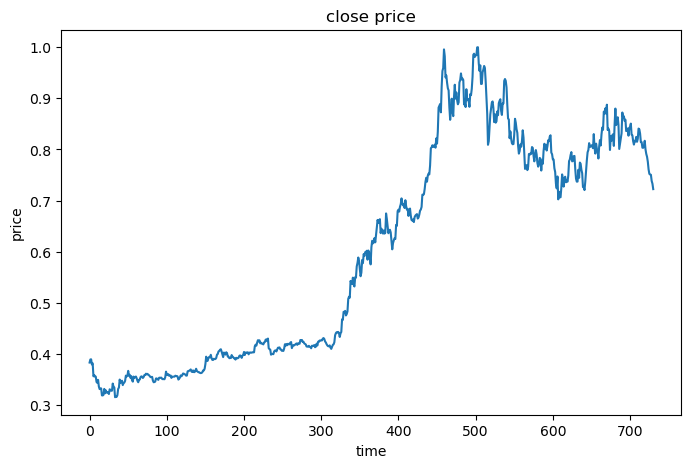

In [4]:
#jupyter魔术命令，可视化
%matplotlib inline 
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize = (8,5)) # 创建一个具有指定大小的图形对象
plt.plot(price_norm) #归一化之后的样子，若要归一化之前的样子则(price)
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

<h1>数据预处理</h1>

data[i:i+time_step]：表示从data列表中索引i到i+time_step-1之间的元素切片.  
[a for a in data[i:i+time_step]]：使用列表推导式，遍历切片中的每个元素，并将它们添加到新的列表中.  
x.append([a for a in data[i:i+time_step]])：将生成的列表作为一个整体添加到列表x的末尾.  

In [5]:
#define x,y
#difine method to extract X and Y 让他适合RNN输入序列
#0,1,2,3,4,5,6,7,8,9:10个样本; time_step = 8; 0,1,2,3,4,5,6,7(第一组); 1,2,3,4,5,6,7,8(第二组); 
#2,3,4,5,6,7,8,9(没有需要预测的数据，因此不算做一组样本); 因此一共只有2组样本
#y是目标值，是一维数组，但是x需要进行转化
def extract_data(data,time_step):
    x = []
    y = []
    for i in range(len(data) - time_step): #731 - 8 = 723 一共两组样本
        x.append([a for a in data[i:i+time_step]])
        y.append(data[i+time_step])
    x = np.array(x) #将x转换为数组
    x = x.reshape(x.shape[0],x.shape[1],1)   # x有三个维度：样本数, time_step, 数组本身的维度
    y = np.array(y)
    return x,y

In [6]:
time_step = 8
x,y = extract_data(price_norm,time_step)
print(x.shape) 

(723, 8, 1)


723代表我有723个样本，8代表每个样本里有多少个数据点，1代表每个数据点就是单独的一个数值（每个时间步中有1个特征维度的数据）

In [7]:
print(x[0,:])#打印第一个样本，选择了第一个样本的所有时间步和所有特征维度的值。

[[0.38327341]
 [0.38926621]
 [0.38966573]
 [0.37954455]
 [0.3818085 ]
 [0.35637235]
 [0.35876948]
 [0.35583966]]


In [8]:
print(y)

[0.35583966 0.34531895 0.34358769 0.34944733 0.33639632 0.33133573
 0.33226795 0.33280064 0.31908377 0.31895059 0.32001598 0.33173525
 0.32307897 0.32893861 0.32454388 0.3254761  0.32481023 0.32174724
 0.33093621 0.32987082 0.32813957 0.32827274 0.34225596 0.3359968
 0.33479824 0.31548808 0.31735251 0.31615395 0.31948329 0.33173525
 0.33439872 0.34998002 0.34332135 0.34665069 0.34771607 0.33919297
 0.34318817 0.34412039 0.34744973 0.35770409 0.35597283 0.35757091
 0.36702624 0.35730457 0.35943534 0.35330936 0.35677187 0.34878146
 0.34598482 0.35583966 0.35344254 0.35490744 0.35597283 0.35251032
 0.3475829  0.34478626 0.34944733 0.34998002 0.35477427 0.35623918
 0.35583966 0.35317619 0.35504062 0.35876948 0.35890265 0.36156612
 0.36023439 0.3611666  0.35943534 0.35850313 0.35650553 0.35477427
 0.35504062 0.35530696 0.34798242 0.34478626 0.34518578 0.34598482
 0.3521108  0.35224397 0.35077907 0.34944733 0.35344254 0.35370888
 0.35357571 0.35370888 0.35117859 0.35077907 0.35104541 0.35064

<h1>Set up model</h1>
激活函数'RELU':当输入x大于等于0时，输出为x本身；当输入x小于0时，输出为0
    
定义神经元为5的的RNN模型，这里不需要样本数了，所以只有2个维度

进行回归预测时，直接用linear而不是用softmax和sigmoid
 
 

In [9]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
model = Sequential() #实例
# add RNN layer
model.add(SimpleRNN(units = 5, input_shape = (time_step, 1),activation = 'relu')) 
# add output layer (output:y)
model.add(Dense(units = 1, activation = 'linear')) # 输出的维度为1; 线性激活函数就是 f(x) = x
#config model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5)                 35        
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<h1>模型训练</h1>
batch_size：批处理大小，表示每次迭代使用的样本数量。在训练过程中，模型会根据这个值将数据分成多个小批次进行训练。

epochs：训练轮数，表示模型将遍历整个数据集的次数。

model.fit() 方法通过传入输入数据和对应的目标数据来训练模型。它会根据指定的批处理大小和训练轮数，
按照一定的顺序和算法来更新模型的权重，以使模型能够逐渐拟合输入数据和目标数据之间的关系。
训练过程中，模型会根据损失函数计算预测结果与真实结果之间的差异，并通过反向传播来调整权重。

在每个训练轮次中，模型会将数据集划分为多个小批次（每批次大小为batch_size），并使用梯度下降算法来优化模型。
一个完整的数据集被遍历一次称为一个训练轮次（epoch），而多个训练轮次的迭代则可以更好地拟合数据集。

In [10]:
# modify sample
print(x.shape[0],len(y))

723 723


In [11]:
#train model
model.fit(x,y,batch_size = 30,epochs = 200)

Epoch 1/200
25/25 [==============================] - 0s 987us/step - loss: 1.0280
Epoch 2/200
25/25 [==============================] - 0s 869us/step - loss: 0.2645
Epoch 3/200
25/25 [==============================] - 0s 892us/step - loss: 0.1140
Epoch 4/200
25/25 [==============================] - 0s 822us/step - loss: 0.0642
Epoch 5/200
25/25 [==============================] - 0s 862us/step - loss: 0.0338
Epoch 6/200
25/25 [==============================] - 0s 821us/step - loss: 0.0165
Epoch 7/200
25/25 [==============================] - 0s 824us/step - loss: 0.0076
Epoch 8/200
25/25 [==============================] - 0s 830us/step - loss: 0.0037
Epoch 9/200
25/25 [==============================] - 0s 807us/step - loss: 0.0022
Epoch 10/200
25/25 [==============================] - 0s 817us/step - loss: 0.0017
Epoch 11/200
25/25 [==============================] - 0s 796us/step - loss: 0.0014
Epoch 12/200
25/25 [==============================] - 0s 778us/step - loss: 0.0013
Epoch 13/200


Epoch 96/200
25/25 [==============================] - 0s 821us/step - loss: 2.6210e-04
Epoch 97/200
25/25 [==============================] - 0s 800us/step - loss: 2.6231e-04
Epoch 98/200
25/25 [==============================] - 0s 822us/step - loss: 2.6441e-04
Epoch 99/200
25/25 [==============================] - 0s 826us/step - loss: 2.6250e-04
Epoch 100/200
25/25 [==============================] - 0s 832us/step - loss: 2.6233e-04
Epoch 101/200
25/25 [==============================] - 0s 834us/step - loss: 2.6193e-04
Epoch 102/200
25/25 [==============================] - 0s 789us/step - loss: 2.6405e-04
Epoch 103/200
25/25 [==============================] - 0s 806us/step - loss: 2.6273e-04
Epoch 104/200
25/25 [==============================] - 0s 837us/step - loss: 2.6383e-04
Epoch 105/200
25/25 [==============================] - 0s 817us/step - loss: 2.6169e-04
Epoch 106/200
25/25 [==============================] - 0s 822us/step - loss: 2.6145e-04
Epoch 107/200
25/25 [===============

25/25 [==============================] - 0s 797us/step - loss: 2.5699e-04
Epoch 190/200
25/25 [==============================] - 0s 866us/step - loss: 2.5867e-04
Epoch 191/200
25/25 [==============================] - 0s 816us/step - loss: 2.5558e-04
Epoch 192/200
25/25 [==============================] - 0s 888us/step - loss: 2.5474e-04
Epoch 193/200
25/25 [==============================] - 0s 792us/step - loss: 2.5104e-04
Epoch 194/200
25/25 [==============================] - 0s 813us/step - loss: 2.5053e-04
Epoch 195/200
25/25 [==============================] - 0s 791us/step - loss: 2.4880e-04
Epoch 196/200
25/25 [==============================] - 0s 822us/step - loss: 2.5079e-04
Epoch 197/200
25/25 [==============================] - 0s 836us/step - loss: 2.5198e-04
Epoch 198/200
25/25 [==============================] - 0s 818us/step - loss: 2.4906e-04
Epoch 199/200
25/25 [==============================] - 0s 835us/step - loss: 2.4942e-04
Epoch 200/200
25/25 [=========================

<h1>可视化预测结果</h1>

In [14]:
# predict on training data
y_train_predict = model.predict(x) * max(price) #之前x归一化过，则需要反归一化
y_train = y * max(price)
print(y_train_predict) #y的预测值

23/23 [==============================] - 0s 796us/step
[[26.436321]
 [27.83275 ]
 [25.826971]
 [26.83467 ]
 [26.227797]
 [25.562807]
 [25.633003]
 [25.290226]
 [25.619923]
 [24.238987]
 [25.058558]
 [24.33962 ]
 [25.689928]
 [24.10939 ]
 [25.721   ]
 [24.027878]
 [25.404093]
 [24.322735]
 [24.985867]
 [25.189999]
 [24.900642]
 [25.181932]
 [24.802526]
 [26.19185 ]
 [24.877743]
 [25.863415]
 [23.594873]
 [25.27581 ]
 [23.751463]
 [25.291739]
 [25.015303]
 [25.380095]
 [26.366962]
 [25.125456]
 [26.611813]
 [25.523888]
 [26.008999]
 [25.983032]
 [26.021845]
 [26.474882]
 [26.74678 ]
 [26.611513]
 [26.90123 ]
 [27.288696]
 [26.58516 ]
 [27.31184 ]
 [26.229965]
 [27.4573  ]
 [25.820513]
 [26.847546]
 [26.668056]
 [26.617052]
 [26.876518]
 [26.573067]
 [26.66905 ]
 [26.134117]
 [26.275185]
 [26.554602]
 [26.351988]
 [26.914148]
 [26.574104]
 [26.830635]
 [26.416166]
 [26.878033]
 [26.897133]
 [26.980614]
 [27.175596]
 [26.924768]
 [27.213406]
 [26.855055]
 [27.118591]
 [26.765251]
 [26.8703

In [15]:
print(y_train) #y在训练集中的真实值

[26.72 25.93 25.8  26.24 25.26 24.88 24.95 24.99 23.96 23.95 24.03 24.91
 24.26 24.7  24.37 24.44 24.39 24.16 24.85 24.77 24.64 24.65 25.7  25.23
 25.14 23.69 23.83 23.74 23.99 24.91 25.11 26.28 25.78 26.03 26.11 25.47
 25.77 25.84 26.09 26.86 26.73 26.85 27.56 26.83 26.99 26.53 26.79 26.19
 25.98 26.72 26.54 26.65 26.73 26.47 26.1  25.89 26.24 26.28 26.64 26.75
 26.72 26.52 26.66 26.94 26.95 27.15 27.05 27.12 26.99 26.92 26.77 26.64
 26.66 26.68 26.13 25.89 25.92 25.98 26.44 26.45 26.34 26.24 26.54 26.56
 26.55 26.56 26.37 26.34 26.36 26.33 26.64 27.45 27.02 26.94 27.07 26.84
 26.87 26.88 26.53 26.71 26.71 26.7  26.71 26.85 26.79 26.81 26.73 26.28
 26.41 26.58 26.89 26.77 26.91 27.17 27.15 27.07 27.03 26.86 26.87 27.49
 27.54 27.57 27.67 27.77 27.46 27.39 27.63 27.38 27.38 27.6  27.87 27.53
 27.45 27.36 27.36 27.26 27.23 27.26 27.35 27.62 27.62 27.87 28.56 29.64
 29.   29.05 29.51 29.6  29.54 29.92 29.41 29.17 29.17 29.34 29.29 29.3
 29.45 29.94 30.04 30.42 30.49 30.66 30.74 30.4  30.

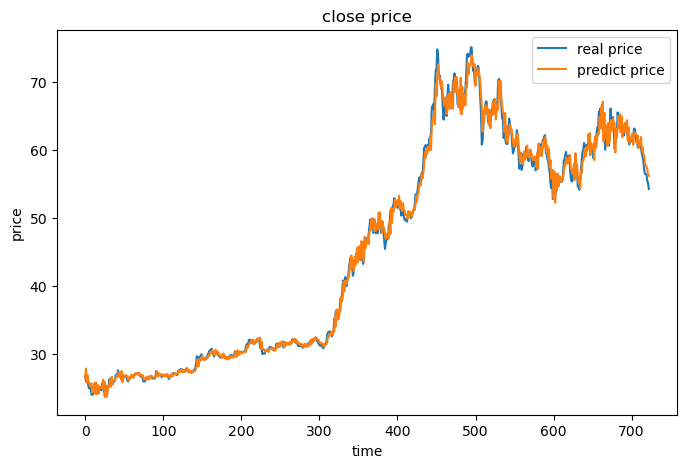

In [18]:
fig2 = plt.figure(figsize = (8,5))
plt.plot(y_train, label = 'real price')
plt.plot(y_train_predict, label ='predict price')
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [19]:
#预测测试数据
data_test = pd.read_csv('zgpa_test.csv')
data_test.head()

,date,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
0,2022-12-09,47.07,47.88,47.60,46.70,709578.88,0.45,0.95,47.234,45.676,43.869,849621.35,914375.63,753374.44,0.66
1,2022-12-08,46.38,47.20,47.15,46.30,448364.06,0.45,0.96,46.638,45.191,43.505,829263.00,903213.72,770229.27,0.41
2,2022-12-07,47.44,47.48,46.70,46.37,831454.75,-0.74,-1.56,46.174,44.656,43.071,911455.49,883284.96,763969.84,0.77
3,2022-12-06,47.28,47.68,47.44,46.74,878273.06,0.16,0.34,45.824,44.163,42.654,978167.71,845101.53,735781.44,0.81
4,2022-12-05,45.55,47.31,47.28,45.35,1380436.00,2.66,5.96,45.292,43.616,42.217,1153154.05,804455.59,710391.92,1.27


In [21]:
price_test = data_test.loc[:,'close']
price_test.head()

0    47.60
1    47.15
2    46.70
3    47.44
4    47.28
Name: close, dtype: float64

In [22]:
#Extract x_test, y_test
price_test_norm = price_test/max(price) #与之前用同样的归一化方法，防止预测不准
x_test_norm, y_test_norm = extract_data(price_test_norm, time_step)
print(x_test_norm.shape,len(y_test_norm)) #打印维度

(219, 8, 1) (219,)


7/7 [==============================] - 0s 868us/step


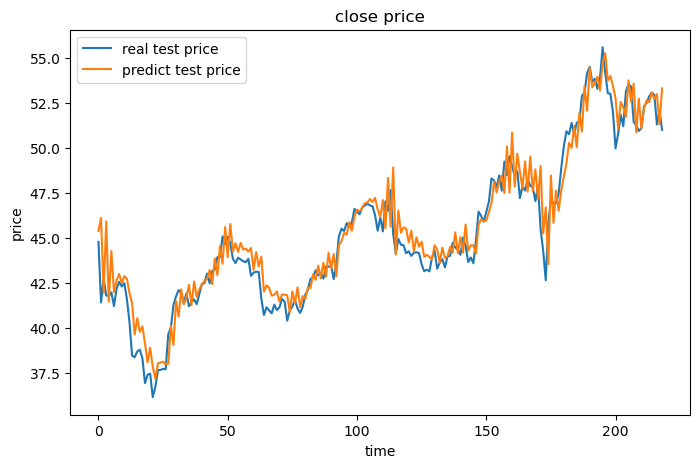

In [25]:
# predict on test data
y_test_predict = model.predict(x_test_norm)*max(price)
y_test = y_test_norm*max(price)
fig3 = plt.figure(figsize = (8,5))
plt.plot(y_test, label = 'real test price')
plt.plot(y_test_predict, label ='predict test price')
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

<h1>存储预测结果，并观察局部预测结果</h1>
在局部上有时候在一个时间点下降了，但是预测还在上升，慢了一拍（信息延迟）

In [37]:
#将两个数组 y_test 和 y_test_predict 沿着轴 Axis=1 进行拼接。
result_y_test = y_test.reshape(-1,1) #-1自动计算行数
result_y_test_predict = y_test_predict
result = np.concatenate((result_y_test,result_y_test_predict),axis = 1)
result = pd.DataFrame(result,columns = ['real test price','predict test price'])
result.to_csv('zgpa_predict_test.csv')